# Preparación para el TF MDS

## Modelación

Dataset: https://www.yelp.com/dataset/documentation/main

**Requiere ejecución prévia del notebook 01_Preparación_flat_toy_dataset.ipynb** para crear dataframes de train y test.

Se utiliza una CNN muy básica y un toy dataset con 100 fotos de cada label.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, Conv2D, MaxPooling2D
from tensorflow import keras
import time

2022-09-07 15:37:06.011213: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-07 15:37:06.011259: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import mlflow
from pathlib import Path

# crear experimento
experiment_id = mlflow.create_experiment(
    "Entrenamiento de CNN",
    artifact_location = 'mlruns2',#Path.cwd().joinpath("mlruns2").as_uri(),
    tags = {"dataset": "flat_toy",
            "photo_size": 100},
)

In [4]:
experiment = mlflow.get_experiment(experiment_id)

# crear run
run = mlflow.start_run(
    run_name="Prueba_de_MLflow",
    experiment_id=experiment_id,
    tags={"Autor": "Pedro_T"},
    description="parent",
)

<ActiveRun: >

In [6]:
# info del run
run_id = run.info.run_id
run = mlflow.active_run()
print("run_id: {}; status: {}".format(run.info.run_id, run.info.status))

run_id: dcf65be3f4ba417cbae15589cc13eb68; status: RUNNING


In [13]:
# activar auto logging
mlflow.tensorflow.autolog()

## Cargar flat toy dataset

In [7]:
X_train = pickle.load(open('checkpoints/flat_toy_X_train.pkl','rb'))

In [8]:
X_test = pickle.load(open('checkpoints/flat_toy_X_test.pkl','rb'))

In [9]:
y_train = pickle.load(open('checkpoints/flat_toy_y_train.pkl','rb'))

In [10]:
y_test = pickle.load(open('checkpoints/flat_toy_y_test.pkl','rb'))

In [11]:
categories = pickle.load(open('checkpoints/flat_toy_categories.pkl','rb'))

In [14]:
print("X_train: {}".format(X_train.shape))
print("y_train: {}".format(y_train.shape))
print("X_test: {}".format(X_test.shape))
print("y_test: {}".format(y_test.shape))

X_train: (400, 100, 100, 3)
y_train: (400, 5)
X_test: (100, 100, 100, 3)
y_test: (100, 5)


#### Visualizamos la imagen pixelada 28 x 28

In [15]:
# Seleccionamos la primera imagen del conjunto (primer dígito)
single = X_train[0]
print("Formato de la imagen: {}".format(single.shape))

Formato de la imagen: (100, 100, 3)


#### Definición de parámetros

In [16]:
batch_size = 128
num_classes = 5
epochs = 2

# Dimensiones de la imagen de entrada
img_rows, img_cols, img_ch = 100, 100, 3

In [17]:
# Si el formato de las imágenes sólo tiene un canal (escala de grises)
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], img_ch, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], img_ch, img_rows, img_cols)
    input_shape = (img_ch, img_rows, img_cols)
# en otro caso
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, img_ch)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_ch)
    input_shape = (img_rows, img_cols, img_ch)

##### Comprobamos el nuevo formato de "x_train" y "x_test"

In [18]:
print("Conjunto de Training: {}".format(X_train.shape[0]), 'imágenes')
print(X_train.shape)

print()
print("Conjunto de TEST: {}".format(X_test.shape[0]), 'imágenes')
print(X_test.shape)

Conjunto de Training: 400 imágenes
(400, 100, 100, 3)

Conjunto de TEST: 100 imágenes
(100, 100, 100, 3)


In [19]:
# Píxeles de la fila 10 de la primera imagen
print(X_train[0][10])

[[103  76  52]
 [ 79  52  31]
 [ 69  42  25]
 [ 63  41  23]
 [ 68  48  29]
 [ 77  60  38]
 [ 59  38  15]
 [ 83  64  37]
 [ 92  76  49]
 [102  91  61]
 [112 106  71]
 [137 134  95]
 [147 145  99]
 [161 160 109]
 [154 152  96]
 [118 115  56]
 [115 112  50]
 [128 123  62]
 [172 168 109]
 [193 189 131]
 [147 145  91]
 [102  98  50]
 [162 150 110]
 [156 138 100]
 [150 126  85]
 [139 109  65]
 [147 112  67]
 [165 129  85]
 [146 111  73]
 [162 128  98]
 [149 118  99]
 [ 71  40  29]
 [ 39   6   2]
 [ 83  41  42]
 [154 101 106]
 [118  55  58]
 [126  53  56]
 [133  65  61]
 [103  55  44]
 [113  75  58]
 [ 93  59  39]
 [202 172 149]
 [203 177 152]
 [154 132 106]
 [151 132 109]
 [155 136 119]
 [ 89  71  62]
 [ 47  28  23]
 [ 48  27  25]
 [ 50  27  26]
 [ 57  30  27]
 [ 64  35  28]
 [ 77  48  37]
 [ 74  43  32]
 [ 86  54  49]
 [101  69  66]
 [100  69  65]
 [ 98  68  62]
 [101  72  63]
 [108  79  70]
 [102  72  64]
 [ 74  43  35]
 [ 53  18  13]
 [ 45   8   2]
 [135  94  88]
 [211 168 156]
 [150 104 

#### Damos formato a los píxeles de las imágenes de coma flotante de simple precisión

In [20]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

#### Normalizamos los píxeles entre [0,1] para que no tengan unos más valor que otros por tener simplemente un número más alto

In [21]:
X_train /= 255
X_test /= 255

#### Visualizamos nuevamente los píxeles de la fila 10 de la primera imagen

In [22]:
print(X_train[0][10])

[[0.40392157 0.29803923 0.20392157]
 [0.30980393 0.20392157 0.12156863]
 [0.27058825 0.16470589 0.09803922]
 [0.24705882 0.16078432 0.09019608]
 [0.26666668 0.1882353  0.11372549]
 [0.3019608  0.23529412 0.14901961]
 [0.23137255 0.14901961 0.05882353]
 [0.3254902  0.2509804  0.14509805]
 [0.36078432 0.29803923 0.19215687]
 [0.4        0.35686275 0.23921569]
 [0.4392157  0.41568628 0.2784314 ]
 [0.5372549  0.5254902  0.37254903]
 [0.5764706  0.5686275  0.3882353 ]
 [0.6313726  0.627451   0.42745098]
 [0.6039216  0.59607846 0.3764706 ]
 [0.4627451  0.4509804  0.21960784]
 [0.4509804  0.4392157  0.19607843]
 [0.5019608  0.48235294 0.24313726]
 [0.6745098  0.65882355 0.42745098]
 [0.75686276 0.7411765  0.5137255 ]
 [0.5764706  0.5686275  0.35686275]
 [0.4        0.38431373 0.19607843]
 [0.63529414 0.5882353  0.43137255]
 [0.6117647  0.5411765  0.39215687]
 [0.5882353  0.49411765 0.33333334]
 [0.54509807 0.42745098 0.25490198]
 [0.5764706  0.4392157  0.2627451 ]
 [0.64705884 0.5058824  0.33

## Convierte los vectores de clase en matrices de clases binarias

In [23]:
# Etiqueta de la primera imagen
print(y_train[0])

[1. 0. 0. 0. 0.]


#### Arquitectura de la CNN

In [24]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

2022-09-07 15:46:51.929449: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-07 15:46:51.929500: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-07 15:46:51.929520: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2389946ad78e): /proc/driver/nvidia/version does not exist
2022-09-07 15:46:51.929736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-07 15:46:51.993561: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 75497472 excee

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 flatten (Flatten)           (None, 147456)            0         
                                                                 
 dense (Dense)               (None, 128)               18874496  
                                                        

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Entrenamos el modelo

In [27]:
start_time = time.time()
model.fit(X_train, y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          verbose=2)
end_time = time.time()

2022-09-07 15:46:54.634709: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 48000000 exceeds 10% of free system memory.


Epoch 1/2


2022-09-07 15:46:55.035804: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 75497472 exceeds 10% of free system memory.


4/4 - 10s - loss: 6.0215 - accuracy: 0.1775 - 10s/epoch - 2s/step
Epoch 2/2
4/4 - 9s - loss: 2.6102 - accuracy: 0.1900 - 9s/epoch - 2s/step


INFO:tensorflow:Assets written to: /tmp/tmpya09f6q8/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpya09f6q8/model/data/model/assets


In [28]:
# Tiempo de entrenamiento
elapsed_time = end_time - start_time
print('Tiempo estimado de entrenamiento (min):', np.around(elapsed_time/60))

Tiempo estimado de entrenamiento (min): 1.0


#### Entrenamiento y evaluación del modelo y tiempo de ejecución

> ##### Entrenamiento: validando con el conjunto de test
> ##### Evaluación del modelo para el conjunto de test
> ##### Tiempo de ejecución

In [29]:
import time

start_time = time.time()

model.fit(X_train, y_train,
          batch_size = batch_size,
          epochs = epochs,
          verbose=2,      # visualización del progreso de entrenamiento
          validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=2)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

elapsed_time = time.time() - start_time

Epoch 1/2
4/4 - 11s - loss: 1.5865 - accuracy: 0.2925 - val_loss: 1.5681 - val_accuracy: 0.2300 - 11s/epoch - 3s/step
Epoch 2/2
4/4 - 10s - loss: 1.5465 - accuracy: 0.2650 - val_loss: 1.5573 - val_accuracy: 0.2800 - 10s/epoch - 3s/step


INFO:tensorflow:Assets written to: /tmp/tmp5fv0zvo_/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp5fv0zvo_/model/data/model/assets


4/4 - 1s - loss: 1.5573 - accuracy: 0.2800 - 553ms/epoch - 138ms/step
Test loss: 1.5572630167007446
Test accuracy: 0.2800000011920929


In [30]:
# Tiempo de entrenmiento
elapsed_time = end_time - start_time
print('Tiempo estimado de entrenamiento (min):', np.around(elapsed_time/60))

Tiempo estimado de entrenamiento (min): -0.0


#### Predecimos el conjunto de TEST con el modelo que hemos diseñado 

##### np.newaxis simplemente aumenta una dimensión a la matriz de la imagen

In [31]:
pred = model.predict(X_test[np.newaxis,1])

1/1 [==============================] - 0s 84ms/step


In [32]:
pred

array([[0.19760773, 0.20281932, 0.20115864, 0.19788215, 0.2005322 ]],
      dtype=float32)

In [33]:
prediccion = pred.argmax(axis=1)

La predicción es: inside


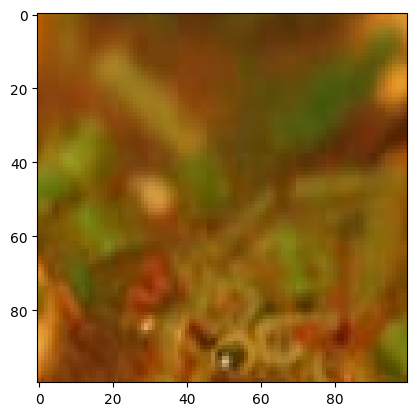

In [34]:
print('La predicción es: {}'.format(categories[prediccion[0]]))  # tiene la posición de la clase que ha tenido mayor probabilidad
img = (X_test[1]*255).reshape((100,100,3)).astype('uint8')
plt.imshow(img)
plt.show()

In [35]:
# terminar Run MLflow
mlflow.end_run()

# mflow ui
## Experimento y run

![flow ui](img/screenshot.JPG)

## Información logueada (parámetros, modelos, etc.)

![mflow ui](img/screenshot2.JPG)